# Weather Data - Data Processing and Analysis

## Importing and Processing Data

In [365]:
import requests
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

USERNAME = 'tmaret@uchicago.edu'
PASSWORD = 'PowerMarket2025'
SUBSCRIPTION_KEY = '9f1e472b26a5439d84f564bf038e46fa' 

AUTH_URL = 'https://ercotb2c.b2clogin.com/ercotb2c.onmicrosoft.com/B2C_1_PUBAPI-ROPC-FLOW/oauth2/v2.0/token'

auth_payload = {
    'username': USERNAME,
    'password': PASSWORD,
    'grant_type': 'password',
    'scope': 'openid fec253ea-0d06-4272-a5e6-b478baeecd70 offline_access',
    'client_id': 'fec253ea-0d06-4272-a5e6-b478baeecd70',
    'response_type': 'id_token'
}

In [322]:
# Make the authentication request.
auth_response = requests.post(AUTH_URL, data=auth_payload)

if auth_response.status_code != 200:
    print("Authentication failed:", auth_response.text)
    sys.exit(1)

auth_data = auth_response.json()
access_token = auth_data.get("access_token")
if not access_token:
    print("Failed to retrieve access token. Response:", auth_data)
    sys.exit(1)

print("Access token retrieved successfully.")

Access token retrieved successfully.


In [329]:
def get_data_ercot(api_url: str, dateFrom="2024-06-05", dateTo="2024-06-06", forecast: bool=False):
    # Define query parameters.
    query_params = {
        "deliveryDateFrom": dateFrom,  # Format: yyyy-mm-dd
        "deliveryDateTo": dateTo,       # Format: yyyy-mm-dd
        "size": 2000000
    }

    # Set up headers with both the subscription key and the access token.
    headers = {
        "Ocp-Apim-Subscription-Key": SUBSCRIPTION_KEY,
        "Authorization": f"Bearer {access_token}",
        "Accept": "application/json"
    }

    # Make the GET request to download the data.
    api_response = requests.get(api_url, headers=headers, params=query_params)

    if api_response.status_code == 200:
        data = api_response.json()
        records = data.get("data", [])
        
        df = pd.DataFrame(records)
        df.columns = [field['name'] for field in data['fields']]
        
        # Ensure postedDatetime is in datetime format.
        df['postedDatetime'] = pd.to_datetime(df['postedDatetime'])
        
        # Sort by postedDatetime first.
        df.sort_values(by='postedDatetime', inplace=True)
        
        if forecast:
            df['expected_posted'] = pd.to_datetime(df['deliveryDate']) - pd.Timedelta(days=1) \
                            + pd.Timedelta(hours=9, minutes=55)

            # Allow a tolerance (for example, 10 minutes) to account for seconds differences.
            tolerance = pd.Timedelta(minutes=10)

            # Keep only rows where the difference between postedDatetime and expected_posted is within the tolerance.
            df = df[abs(df['postedDatetime'] - df['expected_posted']) <= tolerance]

            # For forecasts, drop duplicates (based on deliveryDate and hourEnding), keeping the first (i.e. the forecast)
            df.drop_duplicates(subset=['deliveryDate', 'hourEnding'], keep='first', inplace=True)

            # Remove the helper column.
            df.drop(columns=['expected_posted'], inplace=True)
        else:
            # For actual data, drop duplicates keeping the most recent record for each delivery period.
            df.drop_duplicates(subset=['deliveryDate', 'hourEnding'], keep='last', inplace=True)

        df.sort_values(by=['deliveryDate', 'hourEnding'], inplace=True)
        df.reset_index(drop=True, inplace=True)
        df.index = df.index + 1

        return df
        
    else:
        print(f"API request failed with status {api_response.status_code}: {api_response.text}")

In [330]:
# ERCOT API endpoint for Wind Power Production data
df_wind_2024_actual = get_data_ercot("https://api.ercot.com/api/public-reports/np4-742-cd/wpp_hrly_actual_fcast_geo", "2024-01-01", "2024-12-31", forecast=False)
df_wind_2024_forecast = get_data_ercot("https://api.ercot.com/api/public-reports/np4-742-cd/wpp_hrly_actual_fcast_geo", "2024-01-01", "2024-12-31", forecast=True)

In [331]:
df_wind_2024_forecast

,postedDatetime,deliveryDate,hourEnding,genSystemWide,COPHSLSystemWide,STWPFSystemWide,WGRPPSystemWide,genPanhandle,COPHSLPanhandle,STWPFPanhandle,...,genWest,COPHSLWest,STWPFWest,WGRPPWest,genNorth,COPHSLNorth,STWPFNorth,WGRPPNorth,HSLSystemWide,DSTFlag
1,2023-12-31 09:55:55,2024-01-01,1,NaN,14700.0,14949.6,9638.2,NaN,520.5,520.5,...,NaN,8957.9,9104.3,5652.8,NaN,1698.9,1757.5,1290.0,NaN,False
2,2023-12-31 09:55:55,2024-01-01,2,NaN,13397.4,13614.3,8538.6,NaN,424.4,424.4,...,NaN,8443.0,8540.4,5177.9,NaN,1664.6,1723.0,1256.7,NaN,False
3,2023-12-31 09:55:55,2024-01-01,3,NaN,12194.1,12387.0,7605.6,NaN,345.3,345.3,...,NaN,7998.7,8109.0,4846.0,NaN,1632.8,1683.1,1215.4,NaN,False
4,2023-12-31 09:55:55,2024-01-01,4,NaN,11235.5,11400.4,6900.7,NaN,278.7,278.7,...,NaN,7674.6,7764.6,4588.2,NaN,1599.7,1645.8,1162.6,NaN,False
5,2023-12-31 09:55:55,2024-01-01,5,NaN,9973.7,10127.2,5982.5,NaN,205.4,205.4,...,NaN,7017.7,7117.4,4102.4,NaN,1525.1,1562.6,1077.4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-12-30 09:55:08,2024-12-31,20,NaN,8581.0,8725.6,7303.3,NaN,643.3,658.6,...,NaN,3494.2,3600.9,2803.2,NaN,599.5,599.5,478.2,NaN,False
8780,2024-12-30 09:55:08,2024-12-31,21,NaN,9785.2,9964.6,8415.3,NaN,867.0,885.2,...,NaN,4344.8,4486.7,3617.6,NaN,682.4,682.4,551.6,NaN,False
8781,2024-12-30 09:55:08,2024-12-31,22,NaN,10691.8,10942.7,9269.3,NaN,1082.4,1103.2,...,NaN,5165.8,5348.8,4410.9,NaN,733.4,733.4,591.8,NaN,False
8782,2024-12-30 09:55:08,2024-12-31,23,NaN,11457.2,11711.7,9936.6,NaN,1226.4,1248.5,...,NaN,5923.5,6130.0,5134.7,NaN,785.2,785.2,635.4,NaN,False


In [332]:
additional_cols = ['postedDatetime','deliveryDate', 'hourEnding']
filtered_cols = [col for col in df_wind_2024_forecast.columns if 'COPHSL' in col or 'STWPF' in col]
cols_to_keep = additional_cols + filtered_cols
# Remove duplicates if any.
cols_to_keep = list(dict.fromkeys(cols_to_keep))
df_wind_2024_forecast = df_wind_2024_forecast[cols_to_keep]
df_wind_2024_actual = df_wind_2024_actual[cols_to_keep]
df_wind_2024_forecast

,postedDatetime,deliveryDate,hourEnding,COPHSLSystemWide,STWPFSystemWide,COPHSLPanhandle,STWPFPanhandle,COPHSLCoastal,STWPFCoastal,COPHSLSouth,STWPFSouth,COPHSLWest,STWPFWest,COPHSLNorth,STWPFNorth
1,2023-12-31 09:55:55,2024-01-01,1,14700.0,14949.6,520.5,520.5,1995.6,1998.1,1527.1,1569.2,8957.9,9104.3,1698.9,1757.5
2,2023-12-31 09:55:55,2024-01-01,2,13397.4,13614.3,424.4,424.4,1679.0,1680.2,1186.4,1246.3,8443.0,8540.4,1664.6,1723.0
3,2023-12-31 09:55:55,2024-01-01,3,12194.1,12387.0,345.3,345.3,1358.4,1358.4,858.9,891.2,7998.7,8109.0,1632.8,1683.1
4,2023-12-31 09:55:55,2024-01-01,4,11235.5,11400.4,278.7,278.7,1032.8,1033.5,649.7,677.8,7674.6,7764.6,1599.7,1645.8
5,2023-12-31 09:55:55,2024-01-01,5,9973.7,10127.2,205.4,205.4,716.9,717.7,508.6,524.1,7017.7,7117.4,1525.1,1562.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-12-30 09:55:08,2024-12-31,20,8581.0,8725.6,643.3,658.6,2132.3,2141.8,1711.7,1724.8,3494.2,3600.9,599.5,599.5
8780,2024-12-30 09:55:08,2024-12-31,21,9785.2,9964.6,867.0,885.2,2130.8,2142.3,1760.2,1768.0,4344.8,4486.7,682.4,682.4
8781,2024-12-30 09:55:08,2024-12-31,22,10691.8,10942.7,1082.4,1103.2,1992.4,2037.2,1717.8,1720.1,5165.8,5348.8,733.4,733.4
8782,2024-12-30 09:55:08,2024-12-31,23,11457.2,11711.7,1226.4,1248.5,1838.9,1863.1,1683.2,1684.9,5923.5,6130.0,785.2,785.2


In [337]:
df_solar_2024_forecast = get_data_ercot("https://api.ercot.com/api/public-reports/np4-745-cd/spp_hrly_actual_fcast_geo", "2024-01-01", "2024-12-31", forecast=True)
df_solar_2024_actual = get_data_ercot("https://api.ercot.com/api/public-reports/np4-745-cd/spp_hrly_actual_fcast_geo", "2024-01-01", "2024-12-31", forecast=False)

In [383]:
additional_cols = ['postedDatetime','deliveryDate', 'hourEnding']
filtered_cols = [col for col in df_solar_2024_actual.columns if 'COPHSL' in col or 'STPPF' in col]
cols_to_keep = additional_cols + filtered_cols

df_solar_2024_actual = df_solar_2024_actual[cols_to_keep]
df_solar_2024_forecast = df_solar_2024_forecast[cols_to_keep]
df_solar_2024_forecast.head()

,postedDatetime,deliveryDate,hourEnding,COPHSLSystemWide,STPPFSystemWide,COPHSLCenterWest,STPPFCenterWest,COPHSLNorthWest,STPPFNorthWest,COPHSLFarWest,STPPFFarWest,COPHSLFarEast,STPPFFarEast,COPHSLSouthEast,STPPFSouthEast,COPHSLCenterEast,STPPFCenterEast
1,2023-12-31 09:55:39,2024-01-01,1,24.8,0.0,0.0,0.0,0.0,0.0,24.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-12-31 09:55:39,2024-01-01,2,24.8,0.0,0.0,0.0,0.0,0.0,24.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-12-31 09:55:39,2024-01-01,3,24.8,0.0,0.0,0.0,0.0,0.0,24.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-12-31 09:55:39,2024-01-01,4,24.8,0.0,0.0,0.0,0.0,0.0,24.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2023-12-31 09:55:39,2024-01-01,5,24.8,0.0,0.0,0.0,0.0,0.0,24.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [354]:
df_wind_2024_actual.to_parquet("../Data/df_wind_2024_actual.parquet")
df_wind_2024_forecast.to_parquet("../Data/df_wind_2024_forecast.parquet")
df_solar_2024_actual.to_parquet("../Data/df_solar_2024_actual.parquet")
df_solar_2024_forecast.to_parquet("../Data/df_solar_2024_forecast.parquet")

## Analysis and Plotting

In [413]:
exclude_cols = ['postedDatetime', 'deliveryDate', 'hourEnding']
cols_to_multiply = [col for col in df_wind_2024_forecast.columns if col not in exclude_cols]
df_wind_2024_forecast_temp = df_wind_2024_forecast.copy()[['STWPFSystemWide']]
df_wind_2024_actual_temp = df_wind_2024_actual.copy()[['STWPFSystemWide']]
df_wind_2024_error = np.linalg.norm((df_wind_2024_forecast_temp - df_wind_2024_actual_temp).dropna(), axis=0) / np.linalg.norm(df_wind_2024_actual_temp)
print("Euclidian error (L2): ", df_wind_2024_error[0])

Euclidian error (L2):  0.12331527952077827


/var/folders/vm/mgglb02j0ks_1fvmd84gyw4c0000gn/T/ipykernel_23216/3587230498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_2024_forecast['DateTime'] = pd.to_datetime(df_wind_2024_forecast['deliveryDate']) + pd.to_timedelta(df_wind_2024_forecast['hourEnding'].astype(int), unit='h')


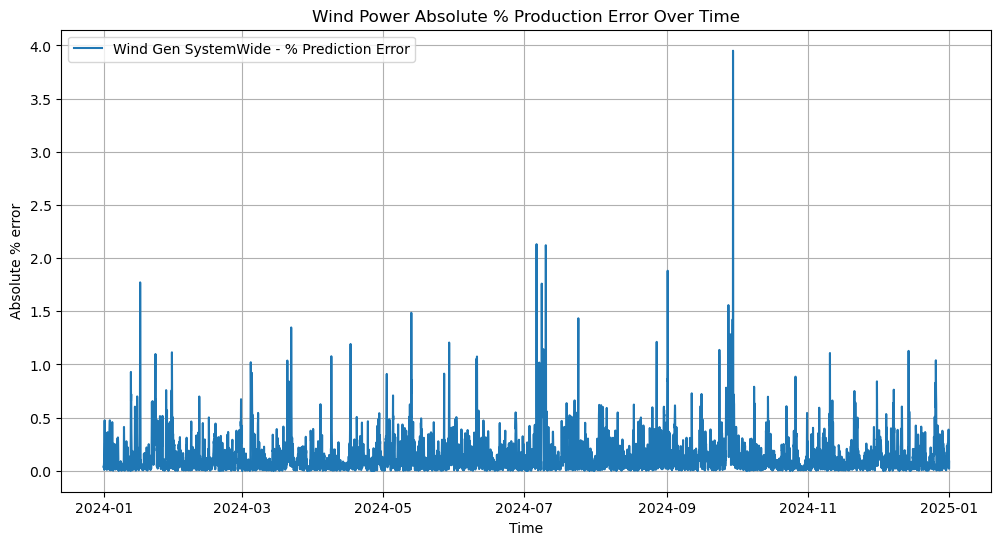

In [ ]:
df_wind_2024_actual['DateTime'] = pd.to_datetime(df_wind_2024_actual['deliveryDate']) + pd.to_timedelta(df_wind_2024_actual['hourEnding'].astype(int), unit='h')
df_wind_2024_forecast['DateTime'] = pd.to_datetime(df_wind_2024_forecast['deliveryDate']) + pd.to_timedelta(df_wind_2024_forecast['hourEnding'].astype(int), unit='h')

plt.figure(figsize=(12, 6))
plt.plot(df_wind_2024_actual['DateTime'], abs(df_wind_2024_actual['STWPFSystemWide'] - df_wind_2024_forecast['STWPFSystemWide']) / df_wind_2024_actual['STWPFSystemWide'], label='Wind Gen SystemWide - % Prediction Error')
plt.xlabel('Time')
plt.ylabel('Absolute % error')

plt.title('Wind Power Absolute % Production Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [415]:
exclude_cols = ['postedDatetime', 'deliveryDate', 'hourEnding']
cols_to_multiply = [col for col in df_solar_2024_forecast.columns if col not in exclude_cols]
df_solar_2024_forecast_temp = df_solar_2024_forecast.copy()[['STPPFSystemWide']]
df_solar_2024_actual_temp = df_solar_2024_actual.copy()[['STPPFSystemWide']]
df_solar_2024_error = np.linalg.norm((df_solar_2024_forecast_temp - df_solar_2024_actual_temp).dropna(), axis=0) / np.linalg.norm(df_solar_2024_actual_temp)
print("Euclidian error (L2): ", df_solar_2024_error[0])

Euclidian error (L2):  0.11056516978700914


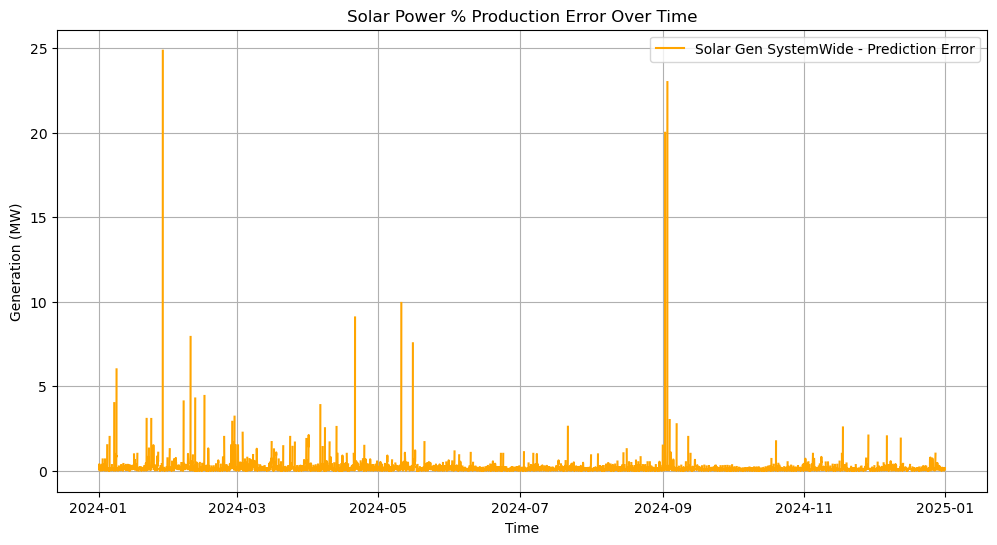

In [ ]:
df_solar_2024_actual['DateTime'] = pd.to_datetime(df_solar_2024_actual['deliveryDate']) + pd.to_timedelta(df_solar_2024_actual['hourEnding'].astype(int), unit='h')
df_solar_2024_forecast['DateTime'] = pd.to_datetime(df_solar_2024_forecast['deliveryDate']) + pd.to_timedelta(df_solar_2024_forecast['hourEnding'].astype(int), unit='h')


plt.figure(figsize=(12, 6))
plt.plot(df_solar_2024_actual['DateTime'], abs(df_solar_2024_actual['STPPFSystemWide'] - df_solar_2024_forecast['STPPFSystemWide']) / df_solar_2024_actual['STPPFSystemWide'], label='Solar Gen SystemWide - % Prediction Error', color = 'orange')
plt.xlabel('Time')
plt.ylabel('Absolute % error')
plt.title('Solar Power Absolute % Production Error Over Time')
plt.legend()
plt.grid(True)
plt.show()